# Model Building 

### How XGBoost Works**

- **Initial Prediction**: Starts with a base prediction, such as the mean for regression.

- **Error Calculation**: Calculates the residuals or errors from the current model.

 - **Model Update**: Fits a new weak learner (decision tree) to the residuals to correct errors.

 - **Combination**: Combines the previous model and the new weak learner using a learning rate to form the final prediction.

### Importing the deep learning Libraries, xgb.

In [ ]:
#if you don't have it then install it with this
!pip install xgb

In [15]:
import xgboost as xgb

###  Initializing the XGBoost Regressor

- *objective='reg:squarederror'* = This parameter specifies the loss function to be minimized.reg:squarederror indicates that we're using squared error as the loss function, which is suitable for regression problems.

- *n_estimators* = Number of boosting rounds
 - *max_depth* = Depth of each tree
 - *learning_rate=0.1* = Shrinkage step

In [16]:
xgbmodel = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100, max_depth=5, learning_rate=0.1, 
    random_state=42)

### Train the model


In [17]:
xgbmodel.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [18]:
# Make predictions
y_pred = xgbmodel.predict(X_test)

#### Experiment with new data (Try/Optional)

In [ ]:
# Replace these with the actual new values you want to predict for.
new_data = [[<AT>, <V>, <AP>, <RH>]]  #25.0, 54.0, 1013.0, 75.0 (for example)

# If feature scaling was applied, transform the new data using the same scaler
# the following code if you used StandardScaler:
# new_data = scaler.transform(new_data)

# Make predictions
predicted_pe = model.predict(np.array(new_data))
# Display the prediction
print(f"Predicted Net Energy Output (PE): {predicted_pe[0]:.4f}")

### Model Evaluation Visualizations 
 - Residual Plot: This is useful to visually inspect the difference between predicted and actual values. You should expect residuals (errors) to be spread evenly around zero. If they are biased in some way, it could indicate that the model isn't capturing some important patterns.


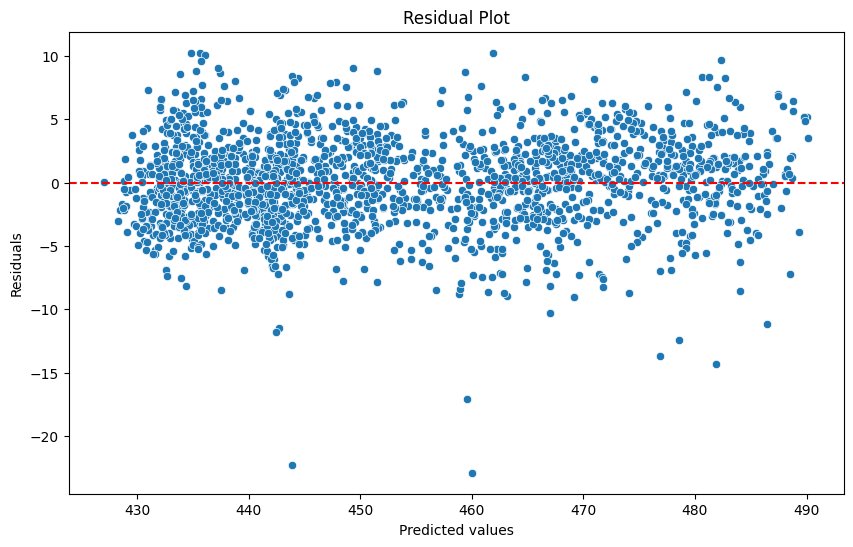

In [19]:
residuals = y_test - y_pred

pt.figure(figsize=(10,6))
sb.scatterplot(x=y_pred, y=residuals)
pt.axhline(y=0, color='r', linestyle='--')
pt.xlabel('Predicted values')
pt.ylabel('Residuals')
pt.title('Residual Plot')

folder_path8 = "E:\plots" 
file_name8 = "RESD_plot.png"
pt.savefig(f"{folder_path8}/{file_name8}", dpi=300, bbox_inches='tight') 
pt.show()

#### Insights from the Residual Plot:
 - Random Scattering Around Zero: The residuals appear randomly scattered around the zero line, indicating that the model captures the data pattern well and does not exhibit clear bias.

 - No Systematic Pattern: There is no discernible pattern (e.g., curved shape, clustering), which suggests that the model does not suffer from systematic errors like underfitting or overfitting.

 - Outliers:Some residuals deviate significantly from the zero line. These points could represent:
Outliers in the data.
Situations where the model struggled to predict accurately.
If these points are minimal and random, they might not significantly impact the overall model.

 - Homoscedasticity:The residuals have a fairly constant spread (variance) across the range of predicted values, which suggests that the model meets the assumption of homoscedasticity.


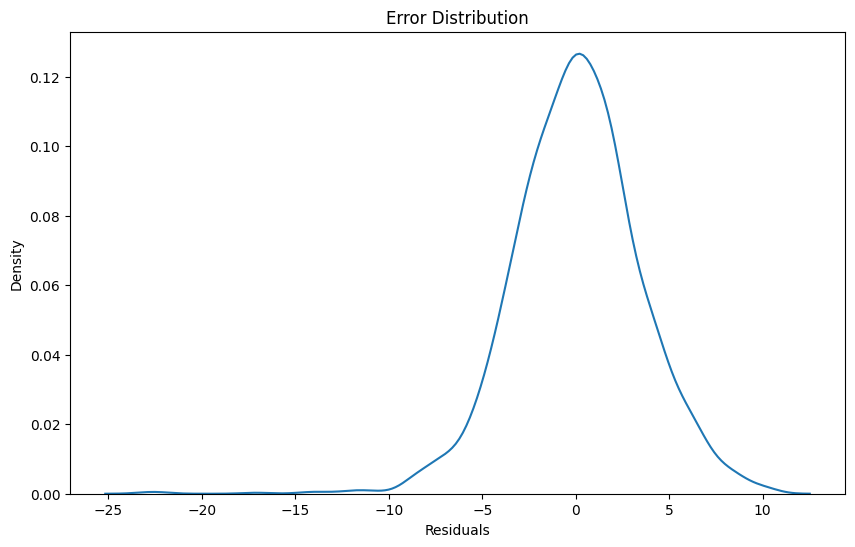

In [54]:
pt.figure(figsize=(10,6))
sb.kdeplot(residuals)
pt.xlabel('Residuals')
pt.title('Error Distribution')
pt.show()

 - Predicted vs Actual Plot: This plot is helpful to visually compare how well the model is performing by plotting the predicted values against the actual values. You should see a diagonal line (45-degree line) if the predictions are close to the actual values.

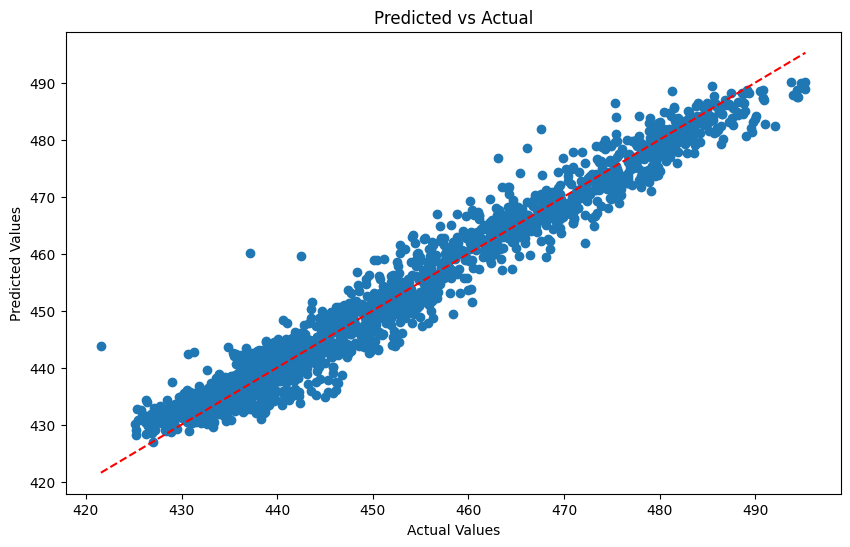

In [46]:
pt.figure(figsize=(10,6))
pt.scatter(y_test, y_pred)
pt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
pt.xlabel('Actual Values')
pt.ylabel('Predicted Values')
pt.title('Predicted vs Actual')
pt.show()

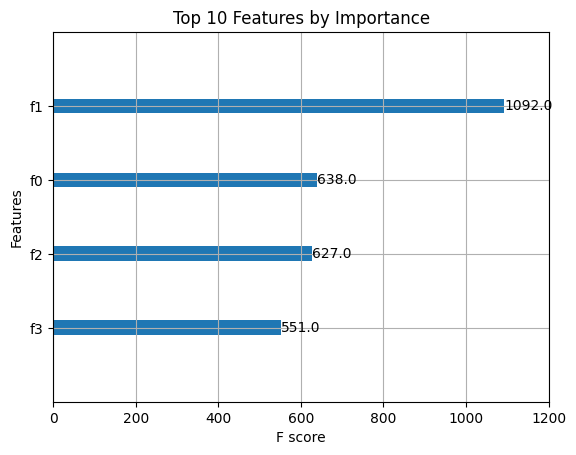

In [51]:
import xgboost as xgb
from xgboost import plot_importance

# Plotting feature importance
plot_importance(xgbmodel, importance_type='weight', max_num_features=10)
pt.title('Top 10 Features by Importance')
pt.show()

###  Evaluate the XGB model

In [183]:
# performance
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

Mean Absolute Error: 2.6003


That's a great result! A Mean Absolute Error (MAE) of 2.6003 without feature scaling and hyperparameter tuning indicates that XGBoost is performing quite well on the CCPP dataset out of the box.

##   Hyperparameter Tuning

 - **Using GridSearchCV to optimize the hyperparameters**

In [185]:
from sklearn.model_selection import GridSearchCV

p_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid = p_grid, scoring='neg_mean_absolute_error', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_) #

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


### Evaluate the best model

In [186]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
print(f"Best Model MAE: {mae_best}")

Best Model MAE: 2.0931940264434967


**The Mean Absolute Error (MAE) of 2.093 after hyperparameter tuning is a significant improvement over the previous results and indicates that the model is performing quite well.**

### Re-training XGBoost model with the best parameters

In [187]:
best_xgbmodel = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=7,
    min_child_weight=1,
    n_estimators=300,
    subsample=0.8,
    random_state=42
)

best_xgbmodel.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [188]:
# Evaluate on the training set and test set

train_predictions = best_xgbmodel.predict(X_train)
test_predictions = best_xgbmodel.predict(X_test)

# MAE
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

Train MAE: 0.948811686122704
Test MAE: 2.0931940264434967


# Model Evaluation

###  Cross-validation for your XGBoost model

In [190]:
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
# Initialize XGBoost model (using the best hyperparameters from tuning)
best_xgbmodel2 = XGBRegressor(
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=7,
    min_child_weight=1,
    n_estimators=300,
    subsample=0.8
)

# Define the scoring function as MAE
mae_scorer = make_scorer(mean_absolute_error)
# Set up KFold cross-validation (5-fold for example)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_results = cross_val_score(best_xgbmodel2, X_train, y_train, cv=kf, scoring=mae_scorer)

In [191]:
# Print the cross-validation results
print(f"Cross-validation MAE scores: {cv_results}")
print(f"Mean MAE: {cv_results.mean():.4f}")
print(f"Standard Deviation: {cv_results.std():.4f}")

Cross-validation MAE scores: [2.17699114 2.25253453 2.23283953 2.24044217 2.28654489]
Mean MAE: 2.2379
Standard Deviation: 0.0356


The mean MAE of 2.2379 is very close to your earlier test set MAE of 2.093, which indicates that the model is generalizing well. The small standard deviation (0.0356) further reinforces this, suggesting that the model's performance is stable across different data splits. This means the model isn't overfitting and has good consistency.

- ***Train MAE***: 0.9488 (This indicates the model fits the training data well, but we should focus more on how it performs on unseen data, i.e., the test set.)
- ***Test MAE***: 2.0932 (This is the MAE on the test data, which is more important as it reflects the model’s generalization ability on new, unseen data.)
- ***Cross-validation MAE (Mean)***: 2.2379 (This is the mean MAE from the cross-validation, which gives you a more robust estimate of the model's performance by averaging it over different folds.)
- ***Cross-validation Standard Deviation***: 0.0356 (This indicates the variance in the model’s performance across different folds. A low standard deviation suggests that the model performs consistently across different subsets of the data.)


## Final Model Evaluation**
#### ✦ **Train MAE: 0.9488**
#### ✦ **Test MAE: 2.0932**
#### ✦ **Cross-validation Mean MAE: 2.2379**
#### ✦ **Cross-validation Standard Deviation: 0.0356**

*Robust Performance: XGBoost outperformed baseline models with a significantly lower MAE (2.093).
Scalability: Its ability to handle large datasets with complex interactions makes it an industry-preferred algorithm.
Insights: Provided valuable information on which factors most impact power output, offering both predictive and prescriptive value.*

> ### How I Tackled the Problem Using XGBoost
1. **Data Exploration and Understanding**
Analyzed the distribution of each feature (AT, V, AP, RH) and their correlation with the target variable (PE).
Identified potential relationships such as negative correlation between Ambient Temperature (AT) and Power Output (PE).

2. **Data Preprocessing**
Checked for missing values and outliers.
Split the dataset into training (80%) and test sets (20%).

3. **Model Selection**
Chose XGBoost Regressor for its ability to handle:
Non-linear relationships between input features and target variables.
Feature importance analysis, which provides insights into which variables are most predictive.

4. **Baseline Model**
Trained the initial XGBoost model without feature scaling or hyperparameter tuning, achieving a baseline Mean Absolute Error (MAE) of 2.6003 on the test set.

5. **Hyperparameter Tuning**
Used GridSearchCV to optimize the following hyperparameters:
learning_rate
max_depth
n_estimators
subsample
colsample_bytree
min_child_weight
Achieved a tuned model with parameters:
*MAE (Test): 2.093
Cross-Validation Mean MAE: 2.237*

6. **Model Validation**
Performed k-fold cross-validation to ensure the model's performance generalized well across multiple subsets of the data.

7. **Model Interpretation**
Feature Importance: Found that Ambient Temperature (AT) had the most significant impact on power output.
Explained the relationship between input features and power output. 

_________________________________________________ **THANK YOU** ________________________________________________________________